# File Description

This notebook contains the most up-to-date version of the pilot model for total water level on Tarawa, currently for only two locations (one hazards side and one ocean side).

Currently needs work:
- Incorporating MEI into network
- Adjusting the binning of the MSL distributions to account for future SLR
- Adding SLR projections as evidence option

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import os
import json
from datetime import datetime
import pysmile
import pysmile_license
import sys
import json
sys.path.append('/src/python_classes')
import rpy2
# os.environ['R_HOME'] = 'C:\ProgramData\Anaconda3\Lib\R'
# %load_ext rpy2.ipython
!jupyter nbextension enable --py --sys-prefix ipyleaflet
from ipywidgets import interact, interactive, fixed, interact_manual
from ipyleaflet import *
import ipywidgets as widgets
from matplotlib.animation import FuncAnimation
import geojson
import folium
from colormap import rgb2hex
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython
from folium.plugins import FloatImage

from BNModel import BNModel
import time

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


# Load the Data

In [3]:
time_start = time.time()
# Load the network
net = pysmile.Network()
net.read_file("test_fragility_network.xdsl")
# Set the evidence
net.set_virtual_evidence("Earthquake_shaking",[1,0,0])
net.set_virtual_evidence("Ts_height",[1,0,0,0])
net.set_virtual_evidence("Liq_severity",[0,0,0,1])
net.set_virtual_evidence("LRO",[1,0])
# Update the beliefs
net.update_beliefs()
net.get_node_value('Combined_fragility')
time_end = time.time()

In [4]:
second_running = (time_end-time_start)
second_running

0.009799480438232422

In [5]:
buildings = 1000
lat_lons = 7000
second_running*lat_lons*buildings/(3600)

19.05454529656304

# Load the test fragility functions

## Earthquake Fragility functions

In [26]:
mu_eq = np.log([0.26,0.55,1.28,2.01])
sigma_eq=([0.64,0.64,0.64,0.64])


In [27]:
bins = np.arange(0,2,0.01)

In [28]:
y = [
        ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    for sigma,mu in zip(sigma_eq,mu_eq)
]
y = [y_i.cumsum() for y_i in y]
y = [y_i/y_i[-1] for y_i in y]

[[<matplotlib.lines.Line2D at 0x7f60d27390d0>],

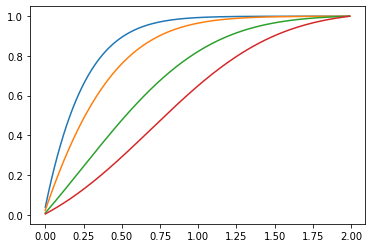

In [29]:
[plt.plot(bins,y_i) for y_i in y]

# Data Prep

## Preprocessing

## Create Variable Dictionary

In [ ]:
#### Don't include spaces in bin names. if no discretisation, just leave out that key
hazards_model_dict = {
    'variables':{
        'meanpga_lo':{
            'label':'meanpga_lo',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':['Liq_Class','land_LP2500_max']
        },
        'Liq_Class':{
            'label':r'Liq_Class',
            'child_nodes':[],
            'bins':np.unique(df_hazards['Liq_Class'])
        },
        'land_LP2500_max':{
            'label':'land_LP2500_max',
            'discretisation':{
                'n_bins':3,
                'strategy':'kmeans',
                'bin_names':['Low','Mid','High']
            },
            'child_nodes':[]
        }
    },
    'training_frac':0.8,
    'bootstrap_reps':1
}

## Bootstrapping the data

In [ ]:
# Bootstrap the data, and add it to the model_dict
hazards_model_dict = BNModel().bootstrap_data(hazards_model_dict,hazards_data_dict,df_hazards)


In [ ]:
hazards_model_dict['variables'].keys()

## Discretise the data

In [ ]:
# Discretise the data
hazards_file_label = "hazards"

hazards_model_dict = BNModel().discretiser(hazards_model_dict,["Liq_Class"])

In [ ]:
# hazards_disc_fig = BNModel().plot_discretiser(hazards_model_dict,["Liq_Class"])

## Save the data

In [ ]:
BNModel().save_dataset(hazards_model_dict,hazards_file_label)

# Create BN Model

In [ ]:
# Create the BN
hazards_model_dict = BNModel().create_SM(hazards_model_dict,hazards_file_label)

## View Conditional Probability tables

In [ ]:
# Get conditional probs tables
BNModel().get_conditional_prob_table(hazards_model_dict,'land_LP2500_max')

In [ ]:
# # Get conditional probs tables
# df_CPT_MSL = BNModel().get_conditional_prob_table(ocean_model_dict,'TWL')

# df_CPT_MSL = df_CPT_MSL.loc[['VeryLow','Low','Mid','High','VeryHigh']]

# plt.pcolor(df_CPT_MSL)

# Set Evidence

In [ ]:
hazards_evidence_dict = {
    'land_LP2500_max':[0.05,0.1,0.01]
}


In [ ]:
hazards_model_dict = BNModel().add_evidence_to_dict(hazards_model_dict,hazards_evidence_dict)

# Update beliefs based on evidence

In [ ]:
# Set evidence and get beliefs
hazards_model_dict = BNModel().update_evidence(hazards_model_dict)

# BN Visualisation

In [ ]:

# Set up graph
graph_hazards = BNModel().create_BN_graph()

# Create nodes of the graph
graph_hazards,hazards_model_dict = BNModel().create_nodes(graph_hazards,hazards_model_dict,0)

# Create arcs between nodesb
graph_hazards = BNModel().create_arcs(graph_hazards,hazards_model_dict)

# Save as dot file
graph_hazards.render(filename='graph_hazards',format='png')

# Plot the graph
graph_hazards
